<a href="https://colab.research.google.com/github/LaraN01/DrugData_AdverseEvents/blob/main/Notebook_4_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import the libraries

In [1]:
import os
default_n_threads = 8
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline


# 2. Load the data

In [3]:
# To activate when running on colab:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
#dataset_path = '/content/drive/MyDrive/CAS_2023/final_dataset.csv'
dataset_path = r"C:\Users\herzr\Desktop\Gitignore\final_dataset.csv"

In [5]:
data=pd.read_csv(dataset_path,index_col=0, dtype={
    'UNII Codes for Inactive Ingredients':'O',
    'UNII Codes for Active Ingredients':'O',
    'Routes of Administration':'O',
    'Product Types':'O',
    'charge':'f4',
    'count':'f4',
    'stereochemistry':'O',
    'defined_stereo':'f4',
    'ez_centers':'f4',
    'molecular_weight':'f4',
    'optical_activity':'O',
    'stereo_centers':'f4',
    'patientsex':'O',
    'risk score':'f4'} )

# 3. Prepare the dataset

There is three product types: 'HUMAN PRESCRIPTION DRUG', 'HUMAN OTC DRUG', 'CELLULAR THERAPY'.
To select a different one change the target entry in the corresponing field of the loading function below.

Route of administration has as well fifferent options: 'PARENTERAL', 'TOPICAL', 'UROGENITAL', 'ORAL' and 'RESPIRATORY (INHALATION)'. To select the desired one for the training and ML just change the entry in the corresponding field below.

In [6]:
def drugs_dataset(data):
    # Select the product type subcategory and route of aministration subcategory as applicable
    data_human=data[data['Product Types']=='HUMAN PRESCRIPTION DRUG']
    #data_human_parenteral=data_human[data_human['Routes of Administration']=='ORAL']

    # For now removed also patientsex, we may add it again to see if it plays a role
    # Defined_stereo is always identical to stereo_centers, therefore one of the two was removed
    result=data_human.drop(['Routes of Administration','Product Types','defined_stereo','patientsex'], axis=1)

    return result

In [7]:
drugs=drugs_dataset(data)

In [15]:
#file_path = 'drugs.csv'
#drugs.to_csv(file_path, index=False)

# 4. General evaluation (shape, info, describe, distribution)

In [8]:
drugs.head(5)

,UNII Codes for Inactive Ingredients,UNII Codes for Active Ingredients,charge,count,stereochemistry,ez_centers,molecular_weight,optical_activity,stereo_centers,risk score
14,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
15,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
16,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
17,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,9.0
18,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0


In [ ]:
#drugs.columns

In [ ]:

# # Group by 'UNII Codes for Active Ingredients' and calculate mean for 'risk score'
# drugs = drugs.groupby('UNII Codes for Active Ingredients', as_index=False).agg({
#     'risk score': 'mean',
#     'UNII Codes for Inactive Ingredients': 'first',  # Assuming other columns have the same values within groups
#     'charge': 'first',
#     'count': 'first',
#     'stereochemistry': 'first',
#     'ez_centers': 'first',
#     'molecular_weight': 'first',
#     'optical_activity': 'first',
#     'stereo_centers': 'first'})



In [ ]:
# Display the result
# drugs.head()

In [9]:
drugs.shape

(8217234, 10)

In [9]:
drugs=drugs.drop_duplicates()

In [10]:
drugs.shape

(15955, 10)

In [11]:
drugs.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15955 entries, 14 to 9224407
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UNII Codes for Inactive Ingredients  15955 non-null  object 
 1   UNII Codes for Active Ingredients    15955 non-null  object 
 2   charge                               15955 non-null  float32
 3   count                                15955 non-null  float32
 4   stereochemistry                      15955 non-null  object 
 5   ez_centers                           15955 non-null  float32
 6   molecular_weight                     15955 non-null  float32
 7   optical_activity                     15955 non-null  object 
 8   stereo_centers                       15955 non-null  float32
 9   risk score                           15955 non-null  float32
dtypes: float32(6), object(4)
memory usage: 997.2+ KB


In [12]:
drugs.describe()

,charge,count,ez_centers,molecular_weight,stereo_centers,risk score
count,15955.000000,15955.000000,15955.000000,15955.000000,15955.000000,15955.000000
mean,-0.027013,1.095393,0.160639,370.479187,2.356941,8.974302
std,0.626027,0.362391,0.643484,236.465988,3.746050,3.541955
min,-10.000000,1.000000,0.000000,1.007900,0.000000,3.000000
25%,0.000000,1.000000,0.000000,246.093506,0.000000,7.000000
50%,0.000000,1.000000,0.000000,336.471313,1.000000,9.000000
75%,0.000000,1.000000,0.000000,443.409210,3.000000,11.000000
max,3.000000,6.000000,7.000000,3562.182373,40.000000,15.000000


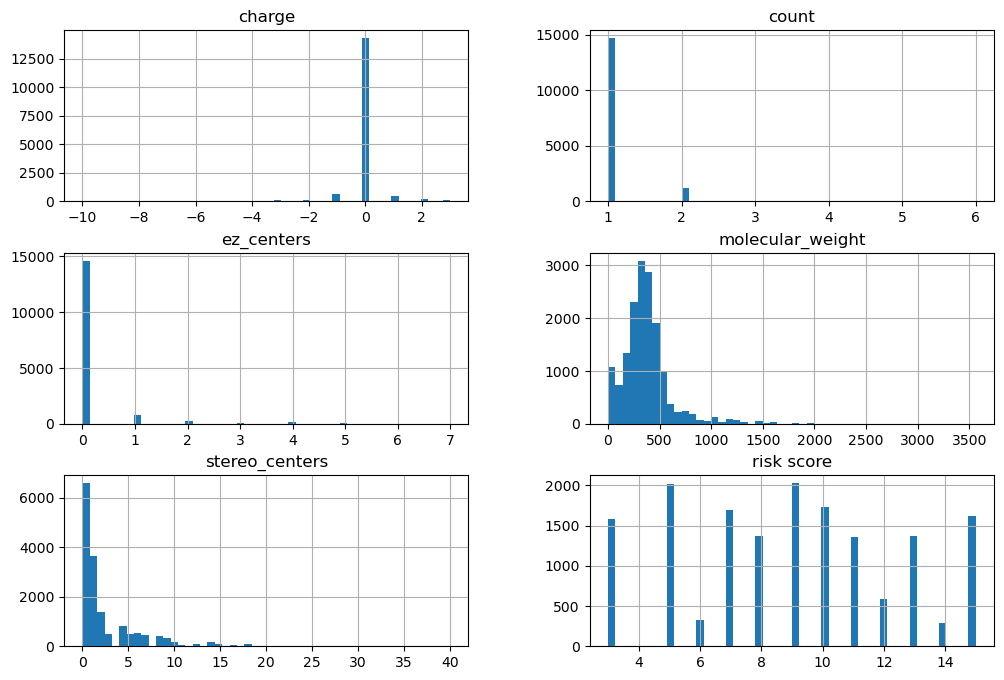

In [13]:
drugs_num=drugs.select_dtypes(include=[np.number])
drugs_num.hist(bins=50, figsize=(12,8))
plt.show()

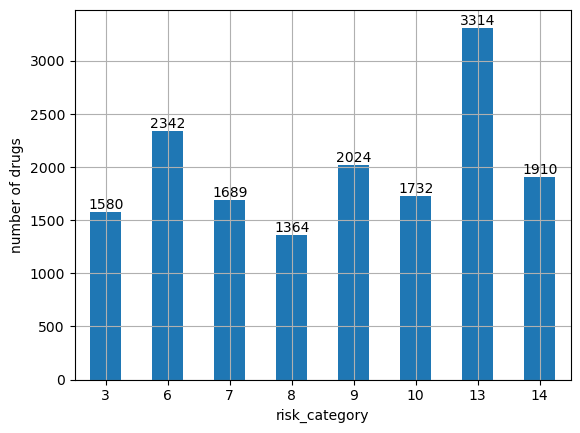

In [16]:
drugs['risk_cat']=pd.cut(drugs['risk score'],
                         bins=[0,3,6,7,8,9,10,13,np.inf],
                         labels=[3,6,7,8,9,10,13,14])   # 3 is all <=3, 6 is 4-6, 13 is 11-13, 14 is >=14

risk_counts=drugs['risk_cat'].value_counts().sort_index()
ax=risk_counts.plot(kind='bar', rot=0, grid=True)
for i, v in enumerate(risk_counts):
    ax.text(i,v +0.1, str(v), ha='center', va='bottom')
plt.xlabel('risk_category')
plt.ylabel('number of drugs')
plt.show()

In [ ]:
# drugs['risk_cat']=pd.cut(drugs['risk score'],
#                          bins=[0,5,8,11,np.inf],
#                          labels=[5,8,11,13])   # 3 is all <=3, 6 is 4-6, 13 is 11-13, 14 is >=14

# risk_counts=drugs['risk_cat'].value_counts().sort_index()
# ax=risk_counts.plot(kind='bar', rot=0, grid=True)
# for i, v in enumerate(risk_counts):
#     ax.text(i,v +0.1, str(v), ha='center', va='bottom')
# plt.xlabel('risk_category')
# plt.ylabel('number of drugs')
# plt.show()

NOTE: ensure that all categories have >=2 entries, if not adapt the bins  
This is required for the stratified splitter

# 5. Train set, test set, validation set

## 5.1 Train set, test set

In [17]:
splitter=StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(drugs, drugs['risk_cat']):
    strat_train_set=drugs.iloc[train_index]
    strat_test_set=drugs.iloc[test_index]

features=['UNII Codes for Inactive Ingredients',
          'UNII Codes for Active Ingredients',
          'charge',
          'count',
          'stereochemistry',
          'ez_centers',
          'molecular_weight',
          'optical_activity',
          'stereo_centers',]

target_feature='risk score'

X_train=strat_train_set[features]
y_train=strat_train_set[target_feature]
X_test=strat_test_set[features]
y_test=strat_test_set[target_feature]

In [18]:
print('X train shape = ', X_train.shape)
print('X test shape = ', X_test.shape)

X train shape =  (12764, 9)
X test shape =  (3191, 9)


# 6. Feature scaling and transformation

## 6.1 Custom transformers

In [19]:
class CustomMultilabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        #print("Fitting CustomMultilabelBinarizer...")
        X = self._apply_eval(X)
        #print("Evaluated input:", X)
        self.mlb.fit(X)
        self.known_classes_ = set(self.mlb.classes_)
        print("Known classes:", self.known_classes_)
        return self

    def transform(self, X):
        #print("Transforming with CustomMultilabelBinarizer...")
        X = self._apply_eval(X)
        #print("Evaluated input:", X)
        filtered_X = [
            [label for label in labels if label in self.known_classes_]
            for labels in X
        ]
        transformed_X = self.mlb.transform(filtered_X)
        #print("Transformed data:", transformed_X)
        return transformed_X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

    def _apply_eval(self, X):
        def safe_eval(x):
            try:
                result = x.split(', ') if isinstance(x, str) else x
                #print(f"Evaluating: {x} -> {result}")
                return result
            except Exception as e:
                #print(f"Error evaluating: {x} with error {e}")
                return []
        return [safe_eval(x) for x in X]


# NOTE: Un-comment the print checks only if needed for debugging/monitoring.
# With print statements require > 15GB RAM and cannot be saved (JSON string too long)

## 6.2 Pipelines and pre-processing

In [20]:
cat_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

mlb_pipeline=make_pipeline(
    CustomMultilabelBinarizer())

num_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    StandardScaler())

log_pipeline=make_pipeline(
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler())

cbrt_pipeline=make_pipeline(
    FunctionTransformer(np.cbrt, feature_names_out='one-to-one'),
    StandardScaler())

In [21]:
preprocessor=ColumnTransformer([
    ('1H_encoded', cat_pipeline,['stereochemistry','optical_activity']),
    ('numericals', num_pipeline,['charge', 'count','ez_centers']),
    ('log_feat', log_pipeline, ['molecular_weight']),
    ('cbrt_feat', cbrt_pipeline, ['stereo_centers']),
    ('mlb', CustomMultilabelBinarizer(), 'UNII Codes for Inactive Ingredients'),
    ('ord_enc',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), ['UNII Codes for Active Ingredients'])])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [22]:
pipeline.fit(X_train)

Known classes: {'25BB7EKE2E', '7SEV7J4R1U', '0A7M0N7SPE', 'ND2M416302', '936JST6JCN', '25IH6R4SGF', 'I29I2VHG38', '1NKX3648J9', '9MC3I34447', 'D9OM4SK49P', 'UKE75GEA7F', 'YRC528SWUY', '399SL044HN', 'RFW2ET671P', '532B59J990', 'C4YAD5F5G6', '0MKJ04EU89', '3DYK7UYZ62', 'G6EP177239', '0IRH2BR587', '7T9FYH5QMK', 'MCU2324216', 'DSO12WL7AU', '1DI56QDM62', '67M3EQ6BE1', '5Y0974F5PW', '4ELV7Z65AP', 'YD01N1999R', 'Q662QK8M3B', '7V4MR24V5P', '2PP9364507', 'LQ35R50VR1', 'ECW0LZ41X8', '1678RKX8RT', '58QVG85GW3', 'ZT934N0X4W', '2ZA36H0S2V', 'G4U024CQK6', '4X49Y0596W', '5WKN5KL2O8', '8136Y38GY5', '40UAA97IT9', '47MLB0F1MV', 'D4D38LT1L5', '2LRS185U6K', '9G1OE216XY', '150CTM9A3J', 'K3R6ZDH4DU', '2968PHW8QP', '32K497ZK2U', 'H5ZC52369M', 'HS7EB0C1ZH', '9O3K93S3TK', 'X7XJ6RM9Q2', 'RDH86HJV5Z', '70097M6I30', '519A78R12Y', '92005F972D', '9B9691B2N9', '6HQ855798J', 'CR6K9C2NHK', 'V8A1AW0880', 'RCZ785HI7S', '23ZQ42JZZH', '83D19O7250', '461P5CJN6T', 'S38J6RZN16', 'ZIF514RVZR', '4N14V5R27W', '1BQV3749L5', 'H0G

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('1H_encoded',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['stereochemistry',
                                                   'optical_activity']),
                                                 ('numericals',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standards...
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'cbrt'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['stereo_centers']),
                                                 ('mlb',
                                                  CustomMultilabelBinarizer(),
                                                  'UNII Codes for Inactive '
                                                  'Ingredients'),
                                                 ('ord_enc',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['UNII Codes for Active '
                                                   'Ingredients'])]))])

In [23]:
X_train_preprocessed = pipeline.transform(X_train)

In [24]:
X_test_preprocessed = pipeline.transform(X_test)

In [25]:
print('Train set shape= ', X_train_preprocessed.shape)
print('Test set shape= ', X_test_preprocessed.shape)

Train set shape=  (12764, 697)
Test set shape=  (3191, 697)


In [26]:
df_X_train_preprocessed=pd.DataFrame(X_train_preprocessed,
                                     columns=preprocessor.get_feature_names_out(),
                                     index=X_train.index)

df_X_test_preprocessed=pd.DataFrame(X_test_preprocessed,
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_test.index)

In [ ]:
# df_X_train_preprocessed.to_csv('/content/drive/MyDrive/CAS_2023/X_train_preprocessed.csv')
# df_X_test_preprocessed.to_csv('/content/drive/MyDrive/CAS_2023/X_test_preprocessed.csv')

In [ ]:
# y_train.to_csv('/content/drive/MyDrive/CAS_2023/y_train')
# y_test.to_csv('/content/drive/MyDrive/CAS_2023/y_test')

In [27]:
df_X_train_preprocessed.head(5)

,1H_encoded__stereochemistry_ABSOLUTE,1H_encoded__stereochemistry_ACHIRAL,1H_encoded__stereochemistry_EPIMERIC,1H_encoded__stereochemistry_MIXED,1H_encoded__stereochemistry_RACEMIC,1H_encoded__optical_activity_( + ),1H_encoded__optical_activity_( + / - ),1H_encoded__optical_activity_NONE,1H_encoded__optical_activity_UNSPECIFIED,numericals__charge,...,mlb__Z78RG6M2N2,mlb__Z82Y2C65EA,mlb__Z8IX2SC1OH,mlb__Z944H5SN0H,mlb__ZF94AP8MEY,mlb__ZIF514RVZR,mlb__ZK64F7XSTX,mlb__ZT934N0X4W,mlb__ZYD53NBL45,ord_enc__UNII Codes for Active Ingredients
2171181,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.666725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.0
820598,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.051749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,922.0
883930,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.051749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,813.0
2349289,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.051749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272.0
1464039,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.051749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0


In [28]:
y_train.describe()

count    12764.000000
mean         8.975400
std          3.542854
min          3.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         15.000000
Name: risk score, dtype: float64

In [29]:
y_test.describe()

count    3191.000000
mean        8.969915
std         3.538729
min         3.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        15.000000
Name: risk score, dtype: float64

In [30]:
df_X_train_preprocessed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12764 entries, 2171181 to 7451255
Data columns (total 697 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    1H_encoded__stereochemistry_ABSOLUTE        float64
 1    1H_encoded__stereochemistry_ACHIRAL         float64
 2    1H_encoded__stereochemistry_EPIMERIC        float64
 3    1H_encoded__stereochemistry_MIXED           float64
 4    1H_encoded__stereochemistry_RACEMIC         float64
 5    1H_encoded__optical_activity_( + )          float64
 6    1H_encoded__optical_activity_( + / - )      float64
 7    1H_encoded__optical_activity_NONE           float64
 8    1H_encoded__optical_activity_UNSPECIFIED    float64
 9    numericals__charge                          float64
 10   numericals__count                           float64
 11   numericals__ez_centers                      float64
 12   log_feat__molecular_weight                  float64
 13   cbrt_f

# 7. Unsupervised learning

## 7.1 t-SNE

### 7.1.1 t-SNE only

In [33]:
import multiprocessing

In [34]:
tsne=TSNE(n_components=2, perplexity=50, learning_rate=250, n_iter=1500, random_state=42, n_jobs=-1, verbose=1)

In [35]:
# Get the number of available CPU cores
num_cores = multiprocessing.cpu_count()
print(f"Number of available CPU cores: {num_cores}")

Number of available CPU cores: 96


In [33]:
sample_size = 10000  # Choose an appropriate sample size
indices = np.random.choice(X_train_preprocessed.shape[0], sample_size, replace=False)
sampled_X_train = X_train_preprocessed[indices]

# Running on the whole dataset takes too long, we run it on a subset of 100000 samples to see if we'd see clusters

In [ ]:
# Parameters for different t-SNE runs
# params = [
#     (sampled_X_train, 30, 200, 1000),
#     (sampled_X_train, 50, 250, 1500),
#     (sampled_X_train, 40, 300, 2000),
#     # Add more parameter combinations if needed
# ]

In [ ]:
# # Run t-SNE in parallel with verbosity
# results = Parallel(n_jobs=-1)(delayed(fit_tsne)(data, p, lr, ni) for data, p, lr, ni in params)

In [40]:
X_tsne=tsne.fit_transform(sampled_X_train)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 0.706s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.350167
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.514900
[t-SNE] KL divergence after 1500 iterations: -0.001837


In [41]:
sampled_y = y_train.iloc[indices] # Labels for the clusters (1-15 is our risk classes: same color = same class)

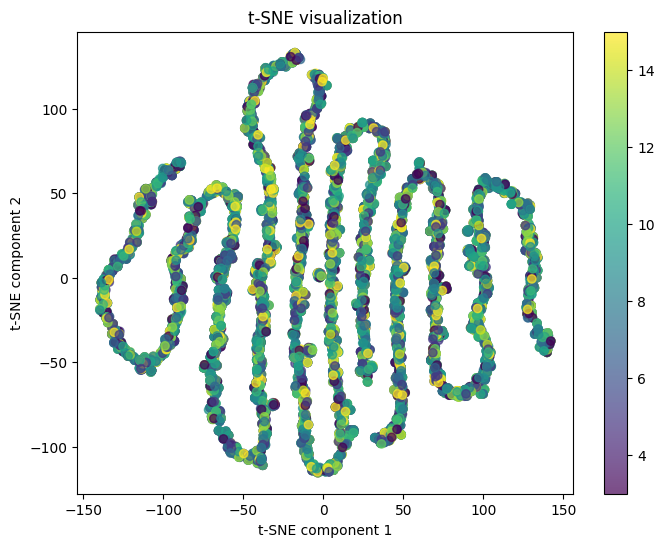

In [42]:
t_SNE_only=plt.figure(figsize=(8, 6))
t_SNE_only_ax = t_SNE_only.add_subplot(111)
scatter_tsne = t_SNE_only_ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sampled_y, cmap=plt.get_cmap('viridis'), alpha=0.7)
t_SNE_only.colorbar(scatter_tsne)
t_SNE_only_ax.set_title('t-SNE visualization')
t_SNE_only_ax.set_xlabel('t-SNE component 1')
t_SNE_only_ax.set_ylabel('t-SNE component 2')
t_SNE_only=plt.savefig('/content/drive/MyDrive/CAS_2023/drop_dupl_t_sne_only.png')
plt.show()

This t-SNE visualization appears to represent a high-dimensional dataset projected into two dimensions. Here are the key points for interpretation:

- Clusters and Structure: The visualization shows a continuous, winding structure with clear density variations. There are no distinct, separate clusters, indicating the data has a continuous rather than discrete distribution.

- Color Gradient: The color gradient on the points suggests another dimension of data represented by color (possibly the value of a third variable). Points in similar colors are close in this dimension, indicating a smooth variation along the structure.

- Interpretation of Axes: The axes, labeled as t-SNE components 1 and 2, do not correspond to the original data dimensions. They are abstract components created by the t-SNE algorithm to best represent the high-dimensional data in two dimensions while preserving the local structure.

- Density Variation: Areas with more closely packed points indicate higher density regions in the original high-dimensional space, whereas sparser areas represent lower density regions.

Overall, this t-SNE plot likely represents a dataset with a complex continuous structure, possibly a manifold, with smooth transitions in some feature represented by the color gradient. The lack of distinct clusters suggests that the data points are related in a continuous manner rather than being grouped into distinct categories.

### 7.1.2 t-SNE on PCA output

In [43]:
# Step 1: Reduce dimensions with PCA

pca = PCA(n_components=50)  # Reduce to 50 components or less
pca_result = pca.fit_transform(sampled_X_train)

In [44]:
# Just temp
tsne=TSNE(n_components=2, perplexity=50, learning_rate=250, n_iter=1000, random_state=42, n_jobs=-1, verbose=2)

# Step 2: Apply t-SNE on the PCA-reduced data
X_tsne = tsne.fit_transform(pca_result)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.178421
[t-SNE] Computed conditional probabilities in 0.405s
[t-SNE] Iteration 50: error = 78.4612961, gradient norm = 0.0173821 (50 iterations in 1.172s)
[t-SNE] I

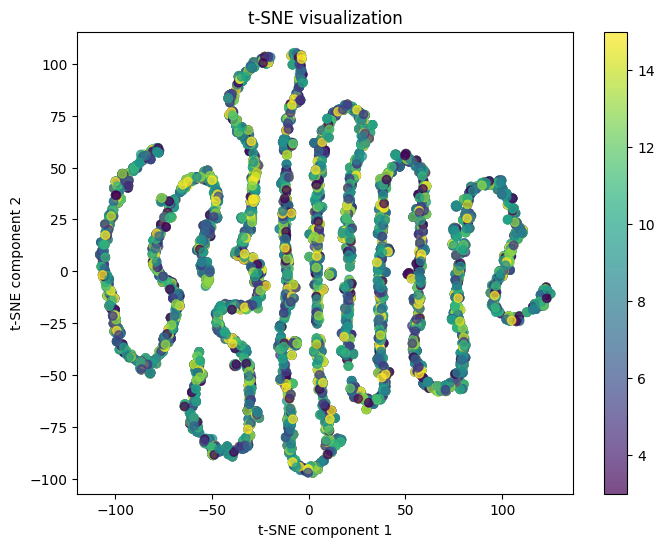

In [46]:
# Step 3: Plot the results
labels=y_train
pca_tsne=plt.figure(figsize=(8, 6))
pca_tsne_ax=pca_tsne.add_subplot(111)
scatter_pca_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sampled_y, cmap=plt.get_cmap('viridis'), alpha=0.7)
pca_tsne.colorbar(scatter_pca_tsne)
pca_tsne_ax.set_title('t-SNE visualization')
pca_tsne_ax.set_xlabel('t-SNE component 1')
pca_tsne_ax.set_ylabel('t-SNE component 2')
pca_tsne=plt.savefig('/content/drive/MyDrive/CAS_2023/drop_dupl_pca_tsne.png')
plt.show()

The updated t-SNE visualization after applying PCA dimensionality reduction shows a similar winding structure to the initial visualization. Here are some additional insights:

- Preservation of Structure: The overall continuous, winding structure is preserved, indicating that the essential relationships and variations in the data are maintained even after applying PCA. This suggests PCA successfully retained the most significant features of the data before t-SNE was applied.

- Variations in Color Gradient: The color gradient still indicates another dimension of data, but the distribution appears slightly more uniform compared to the previous visualization. This might imply a slight reduction in noise or a better representation of the intrinsic data properties after PCA.

- Density and Continuity: The continuous nature of the data is reinforced. The density variations remain similar, with denser regions indicating higher concentrations of data points in the original space.

### 7.1.3 Comparison

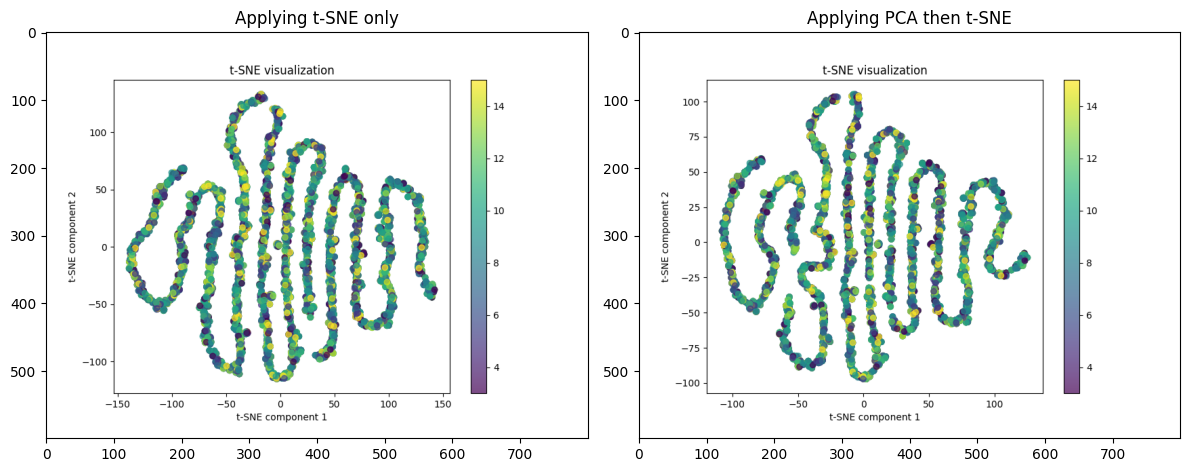

In [48]:
t_SNE_only=np.asarray(Image.open('/content/drive/MyDrive/CAS_2023/drop_dupl_t_sne_only.png'))
pca_tsne=np.asarray(Image.open('/content/drive/MyDrive/CAS_2023/drop_dupl_pca_tsne.png'))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axs[0].imshow(t_SNE_only)
axs[0].set_title('Applying t-SNE only')

axs[1].imshow(pca_tsne)
axs[1].set_title('Applying PCA then t-SNE')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CAS_2023/drop_dupl_t_sne_comparison.png')
plt.show()


Comparing with the initial t-SNE visualization without PCA, the structures are notably similar, but PCA might have helped in reducing the complexity or noise, making the overall pattern more discernible.

Conclusion:

Applying PCA before t-SNE can help in reducing noise and preserving essential features, making the visualization potentially clearer while maintaining the data's continuous structure. This approach is particularly useful when dealing with high-dimensional data to ensure more accurate and interpretable visualizations.


## 7.2 LLE

In [ ]:
import os

# Limit the number of threads used by OpenBLAS
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [49]:
from sklearn.manifold import LocallyLinearEmbedding

In [51]:
lle=LocallyLinearEmbedding(n_components=2,eigen_solver='dense', n_neighbors=10,n_jobs=1, random_state=42)
X_llembedded=lle.fit_transform(sampled_X_train)

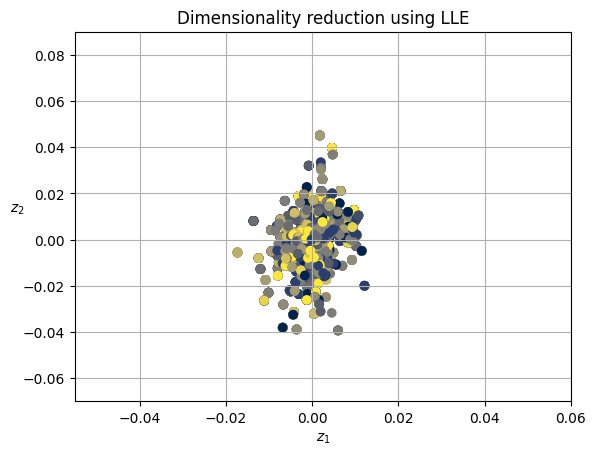

In [53]:
plt.scatter(X_llembedded[:, 0], X_llembedded[:, 1],
            c=sampled_y, cmap='cividis')
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.savefig('/content/drive/MyDrive/CAS_2023/lls.png')
plt.title("Dimensionality reduction using LLE")
plt.show()

The LLE (Locally Linear Embedding) representation in the given plot provides a different perspective compared to the t-SNE visualizations. Here are the key points for interpretation:

1. **Centralized Cluster**: The data points are concentrated around the origin with a relatively small spread, indicating that the LLE method has compressed the data into a dense cluster. This suggests that LLE has captured the local neighborhood relationships in a way that emphasizes similarities, resulting in a compact representation.

2. **Lack of Distinct Structure**: Unlike the t-SNE visualizations, there is no obvious continuous structure or distinct clusters. This can imply that LLE has emphasized local similarities at the expense of global structure, which is typical for LLE as it focuses on preserving local linear relationships.

3. **Color Distribution**: The color gradient, representing another dimension of data, appears to be randomly distributed. This might indicate that the LLE representation does not capture the variance in the data as effectively as t-SNE, or that the variance is more uniformly distributed in this local neighborhood representation.

4. **Dimensional Compression**: The range of values along both \( z_1 \) and \( z_2 \) axes is quite small, suggesting a strong compression of the high-dimensional data into a compact 2D space. This can be beneficial for certain types of data where local neighborhood information is crucial, but might lose some global structural information.

### Conclusion:
The LLE representation shows that the algorithm has compressed the data into a tight cluster, emphasizing local neighborhood relationships while possibly losing some of the global structure. This method is useful when local similarities are more important than the overall global layout, but it may not be as effective for visualizing large-scale structures and patterns in the data compared to t-SNE.

## 7.3 K-means

In [54]:
from sklearn.cluster import KMeans

In [55]:
k=5
kmeans=KMeans(n_clusters=k, random_state=42)

In [57]:
y_pred=kmeans.fit_predict(sampled_X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


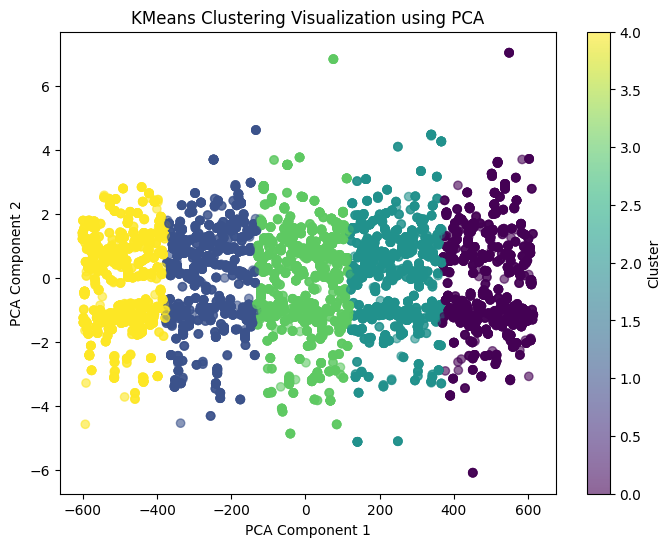

In [59]:
# Use PCA for dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(sampled_X_train)

# Plot the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering Visualization using PCA')
plt.show()


## 7.5 Clustering visualization with dash

In [ ]:
import os

# to avoid memory leak issues with KMeans 
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.express as px
from sklearn.cluster import KMeans
import hdbscan
import umap
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [71]:
df = sampled_X_train

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

app = dash.Dash(__name__)

# Layout 
app.layout = html.Div([
    html.H1("Clustering Visualization"),
    html.Label("Select Clustering Algorithm:"),
    dcc.RadioItems(
        id='clustering-algorithm',
        options=[
            {'label': 'HDBSCAN', 'value': 'hdbscan'},
            {'label': 'KMeans', 'value': 'kmeans'}
        ],
        value='hdbscan',  # Default to HDBSCAN
        inline=True
    ),
    html.Label("Select Visualization Type:"),
    dcc.RadioItems(
        id='viz-type',
        options=[
            {'label': '2D', 'value': '2d'},
            {'label': '3D', 'value': '3d'}
        ],
        value='2d',  # Default to 2D
        inline=True
    ),
    html.Div(id='hdbscan-params', children=[
        html.Label("Select Minimum Cluster Size:"),
        dcc.Slider(
            id='min-cluster-size',
            min=2,
            max=50,
            step=1,
            value=10,
            marks={i: str(i) for i in range(2, 51)}
        ),
        html.Label("Select Minimum Samples:"),
        dcc.Slider(
            id='min-samples',
            min=1,
            max=50,
            step=1,
            value=5,
            marks={i: str(i) for i in range(1, 51)}
        ),
        html.Label("Cluster Selection Epsilon:"),
        dcc.Input(
            id='cluster-selection-epsilon',
            type='number',
            value=0.1,
            step=0.1
        ),
    ]),
    html.Div(id='kmeans-params', style={'display': 'none'}, children=[
        html.Label("Number of Clusters:"),
        dcc.Slider(
            id='num-clusters',
            min=2,
            max=10,
            step=1,
            value=3,
            marks={i: str(i) for i in range(2, 11)}
        ),
    ]),
    html.Button('Update', id='update-button'),
    dcc.Graph(id='cluster-graph'),
    html.Div(id='debug-output', style={'whiteSpace': 'pre-wrap'})
])

@app.callback(
    [Output('hdbscan-params', 'style'), Output('kmeans-params', 'style')],
    [Input('clustering-algorithm', 'value')]
)
def toggle_algorithm_params(algorithm):
    if algorithm == 'hdbscan':
        return {'display': 'block'}, {'display': 'none'}
    else:
        return {'display': 'none'}, {'display': 'block'}

# Callback 
@app.callback(
    [Output('cluster-graph', 'figure'), Output('debug-output', 'children')],
    [Input('update-button', 'n_clicks')],
    [State('clustering-algorithm', 'value'),
     State('viz-type', 'value'),
     State('min-cluster-size', 'value'),
     State('min-samples', 'value'),
     State('cluster-selection-epsilon', 'value'),
     State('num-clusters', 'value')]
)
def update_clusters(n_clicks, algorithm, viz_type, min_cluster_size, min_samples, cluster_selection_epsilon, num_clusters):
    debug_output = ""
    if algorithm == 'hdbscan':
        # HDBSCAN
        model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon)
        clusters = model.fit_predict(df_scaled)
        
        # Debugging (Print unique cluster labels for HDBSCAN)
        unique_clusters = np.unique(clusters)
        debug_output += f"Clusters: {unique_clusters}\n"
        
        if -1 in unique_clusters:
            debug_output += f"Noise points: {np.sum(clusters == -1)}\n"
    elif algorithm == 'kmeans':
        # KMeans
        model = KMeans(n_clusters=num_clusters, n_init=10)
        clusters = model.fit_predict(df_scaled)
        debug_output = ""  # Clear debug output for KMeans

    if viz_type == '2d':
        # Dimension reduction with UMAP 2D
        reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, init='random', n_components=2)
        embedding = reducer.fit_transform(df_scaled)
        
        # 2D scatter plot
        fig = px.scatter(
            x=embedding[:, 0],
            y=embedding[:, 1],
            color=clusters.astype(str),
            title=f'{algorithm.upper()} Clusters (2D)' if algorithm else 'Clusters (2D)'
        )
    elif viz_type == '3d':
        # Dimension reduction with UMAP 3D
        reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, init='random', n_components=3)
        embedding = reducer.fit_transform(df_scaled)
        
        # 3D scatter plot
        fig = px.scatter_3d(
            x=embedding[:, 0],
            y=embedding[:, 1],
            z=embedding[:, 2],
            color=clusters.astype(str),
            title=f'{algorithm.upper()} Clusters (3D)' if algorithm else 'Clusters (3D)'
        )
    else:
        fig = px.scatter()  

    return fig, debug_output

if __name__ == '__main__':
    app.run_server(debug=True)


C:\Users\herzr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Further possible steps:\
    - add more models to the visualization\
    - add more selection tools to the visualization\
    - change the layout to a more user-friendly version\
    - add the possibility to look at different visualizations simultaneously

# 8. Supervised learning

## 8.1 Ensemble learning

In [69]:
rnd_clf=RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                               n_jobs=-1, random_state=42, verbose=1)

In [70]:
rnd_clf.fit(X_train_preprocessed, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.5s finished


RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42, verbose=1)

In [72]:
y_train_pred_rf=cross_val_predict(rnd_clf, X_train_preprocessed, y_train, cv=10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Do

In [73]:
for score, name in zip(rnd_clf.feature_importances_, df_X_train_preprocessed.columns):
    print(f"{round(score, 2)}: {name}")

0.0: 1H_encoded__stereochemistry_ABSOLUTE
0.0: 1H_encoded__stereochemistry_ACHIRAL
0.0: 1H_encoded__stereochemistry_EPIMERIC
0.0: 1H_encoded__stereochemistry_MIXED
0.0: 1H_encoded__stereochemistry_RACEMIC
0.0: 1H_encoded__optical_activity_( + )
0.0: 1H_encoded__optical_activity_( + / - )
0.0: 1H_encoded__optical_activity_NONE
0.0: 1H_encoded__optical_activity_UNSPECIFIED
0.01: numericals__charge
0.0: numericals__count
0.01: numericals__ez_centers
0.04: log_feat__molecular_weight
0.01: cbrt_feat__stereo_centers
0.0: mlb__005990WHZZ
0.0: mlb__023C2WHX2V
0.0: mlb__029TFK992N
0.0: mlb__02F3473H9O
0.0: mlb__02NG325BQG
0.0: mlb__0324G66D0E
0.0: mlb__0345752X7U
0.0: mlb__03DH2IZ3FY
0.0: mlb__043IPI2M0K
0.01: mlb__059QF0KO0R
0.0: mlb__05JZI7B19X
0.0: mlb__06XEA2VD56
0.0: mlb__076NU497LZ
0.0: mlb__07XHK4SAV6
0.0: mlb__099WOY1SA3
0.0: mlb__0A7M0N7SPE
0.0: mlb__0BZ5A00FQU
0.0: mlb__0E53J927NA
0.0: mlb__0HO1H52958
0.0: mlb__0I3V7S25AW
0.0: mlb__0IRH2BR587
0.0: mlb__0MKJ04EU89
0.0: mlb__0QQJ25X58G


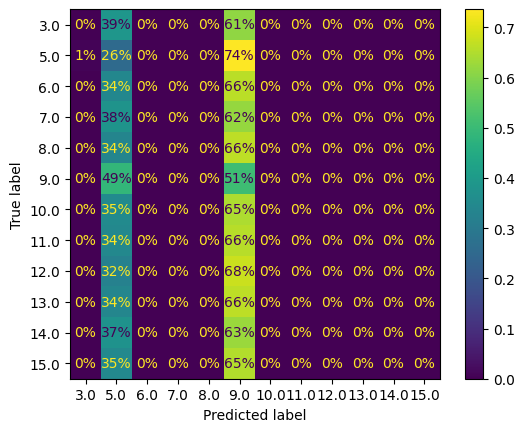

In [74]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf,
                                        normalize='true', values_format=".0%")
plt.show()

High Accuracy for Certain Classes: Some classes, such as 6 and 7, show high diagonal percentages (74% and 66%), indicating that the model performs well in predicting these classes.  
Misclassifications: Some classes have significant misclassifications. For example, class 3 is often misclassified as class 5 (34%), and class 9 as class 8 (25%).  
Zero Predictions: Certain classes have zero predictions for many other classes, indicating that the model did not predict these classes at all.

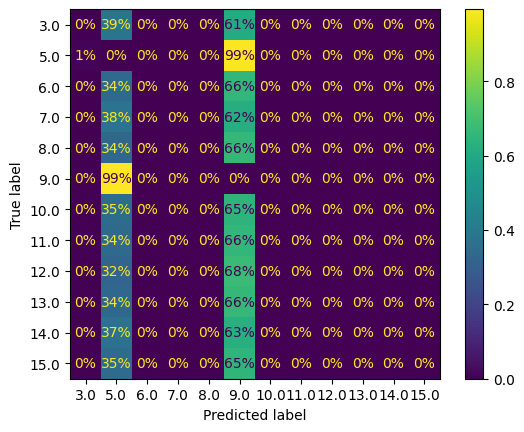

In [76]:
sample_weight=(y_train_pred_rf != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf,
                                        sample_weight=sample_weight,
                                        normalize='true', values_format=".0%")
plt.show()

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_leaf_nodes': [10, 16, 20, 30],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform grid search
grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_preprocessed, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train_preprocessed, y_train)

# Predict with the best model
y_pred_opt = best_model.predict(X_train_preprocessed)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters: {'max_depth': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


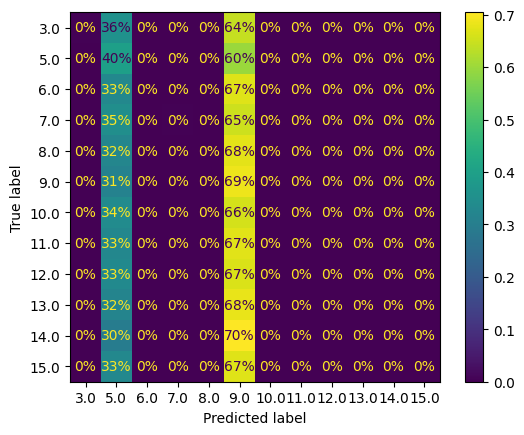

In [78]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_opt,
                                        normalize='true', values_format=".0%")
plt.show()

## 8.2 Stacking

In [81]:
#!pip install xgboost

In [82]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb

In [83]:
# Define the base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Train the stacking classifier
stacking_clf.fit(X_train_preprocessed, y_train)

# Predict using the stacking classifier
y_pred_train = stacking_clf.predict(X_train_preprocessed)

# Evaluate the stacking classifier
accuracy = accuracy_score(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.04677217173299906
Confusion Matrix:
 [[ 18 428   0 117  22 359 141  23   0  37   0 119]
 [161 318   0 168  33 512 181  27   0  51   0 162]
 [ 14  59   0  24   4  78  32   7   0  15   0  28]
 [119 449   0   4  27 378 164  25   0  52   0 133]
 [ 78 321   0 101   0 311 114  19   0  45   0 102]
 [150 588   0 170  34 238 193  30   0  51   0 165]
 [115 473   0 130  35 402  15  25   0  52   0 139]
 [ 75 333   0 109  22 303 111   0   0  41   0  92]
 [ 35 134   0  47   9 128  39   5   0  23   0  41]
 [ 89 343   0 105  21 306 124  21   0   0   0  95]
 [ 23  65   0  18   4  58  21   1   0  11   0  26]
 [105 432   0 139  33 365 148  26   0  49   0   4]]


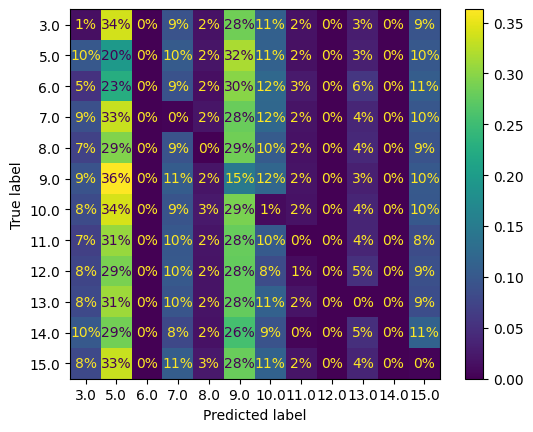

In [84]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,
                                        normalize='true', values_format=".0%")
plt.show()

In [88]:
# # Predict using the stacking classifier
# y_pred_test = stacking_clf.predict(X_test_preprocessed)

# # Evaluate the stacking classifier
# accuracy = accuracy_score(y_test, y_pred_test)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        normalize='true', values_format=".0%")
plt.show()

# 9. Neural Networks

In [89]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## 9.1 Fully connected neural network

In [90]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

unique_labels_encoded = np.unique(y_train_encoded)
print("Unique labels after encoding in y_train:", unique_labels_encoded)

Unique labels after encoding in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [91]:
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels_encoded, y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 0.8415084388185654, 1: 0.6594337673072949, 2: 4.075351213282247, 3: 0.7873180360226992, 4: 0.974946532233425, 5: 0.6569899114679844, 6: 0.7674362674362675, 7: 0.9794352363413137, 8: 2.307302964569776, 9: 0.9634661835748792, 10: 4.68575624082232, 11: 0.8175762234178837}


In [92]:
# Verifications
print("Unique labels in y_train_encoded:", np.unique(y_train_encoded))
print("Unique labels in y_test_encoded:", np.unique(y_test_encoded))
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("X_test_preprocessed shape:", X_test_preprocessed.shape)
print("y_test_encoded shape:", y_test_encoded.shape)

Unique labels in y_train_encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Unique labels in y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11]
X_train_preprocessed shape: (12764, 697)
y_train_encoded shape: (12764,)
X_test_preprocessed shape: (3191, 697)
y_test_encoded shape: (3191,)


In [97]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation='relu', input_shape=(697,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')  # 13 possible classes from 3 to 15
])

In [98]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 300)               209400    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 12)                1212      
                                                                 
Total params: 240712 (940.28 KB)
Trainable params: 240712 (940.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [99]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [100]:
history = model.fit(X_train_preprocessed, y_train_encoded, epochs=30,
                    validation_data=(X_test_preprocessed, y_test_encoded),
                    class_weight=class_weights_dict,
                    batch_size=128)

Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 55.2392 - accuracy: 0.0975 - val_loss: nan - val_accuracy: 0.1069
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 3.3714 - accuracy: 0.0949 - val_loss: nan - val_accuracy: 0.1069
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 2.4872 - accuracy: 0.0561 - val_loss: nan - val_accuracy: 0.1072
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 2.4860 - accuracy: 0.0961 - val_loss: nan - val_accuracy: 0.1065
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 3.4933 - accuracy: 0.0993 - val_loss: nan - val_accuracy: 0.1062
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 2.4853 - accuracy: 0.0893 - val_loss: nan - val_accuracy: 0.1059
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 2.4851 - accuracy: 0.0933 - val_loss: nan - val_accuracy: 0.1059
Epoch 8/30
100/100 [======

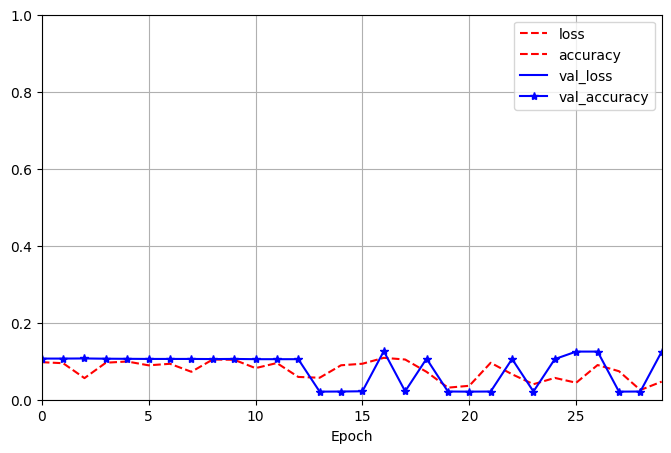

In [101]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim=[0,29], ylim=[0,1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*'])
plt.show()

## 9.2 Fully connected neural network with regularization and hyperparameter tuning

In [102]:
model_reg=tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_dim=X_train_preprocessed.shape[1], activation='relu',),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')  # 13 possible classes from 3 to 15
])

In [103]:
model_reg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               89344     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 12)                396       
                                                                 
Total params: 100076 (390.92 KB)
Trainable params: 100076 (390.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
optimizer=Adam(learning_rate=0.001)
model_reg.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [105]:
# Train the model
history_reg = model_reg.fit(
    X_train_preprocessed, y_train_encoded,
    epochs=100,
    validation_data=(X_test_preprocessed, y_test_encoded),
    batch_size=256,
    callbacks=[early_stopping]
)


Epoch 1/100
50/50 [==============================] - 1s 10ms/step - loss: 8.4812 - accuracy: 0.0942 - val_loss: nan - val_accuracy: 0.1012
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4638 - accuracy: 0.1134 - val_loss: nan - val_accuracy: 0.1250
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4396 - accuracy: 0.1220 - val_loss: nan - val_accuracy: 0.1260
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4213 - accuracy: 0.1307 - val_loss: nan - val_accuracy: 0.1244
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4074 - accuracy: 0.1221 - val_loss: nan - val_accuracy: 0.1238
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4002 - accuracy: 0.1284 - val_loss: nan - val_accuracy: 0.1254
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 2.3882 - accuracy: 0.1279 - val_loss: nan - val_accuracy: 0.1263
Epoch 8/100
50/50 [==============

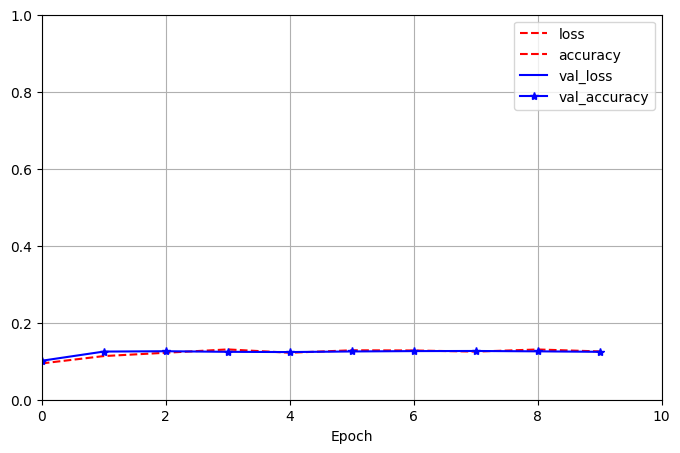

In [106]:
pd.DataFrame(history_reg.history).plot(
    figsize=(8,5), xlim=[0,10], ylim=[0,1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*'])
plt.show()

Possible next steps:  
- Improve the stacking through grid search
- use the K means clusters